In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def merge_dfs(dfs: list[pd.DataFrame]):
    out_df = dfs[0]

    for i in range(1, len(dfs)):
        out_df = pd.merge(out_df, dfs[i], how="left", on=["Country", "Date"])

    return out_df


def generate_indications_cols(df: pd.DataFrame, num_ind: int, label: str, filler):
    new_cols = pd.DataFrame.from_dict([
        {
            f"{label}_ind{indication_num}": filler
                for indication_num in range(1, num_ind+1)
        } 
        for _ in range(len(df))
    ], dtype=float)

    return pd.concat([ df, new_cols ], axis=1)

def fix_date_missing_period(df: pd.DataFrame, col_name="Date"):
    month_map = {
        "janv": "Jan",
        "févr": "Feb",
        "mars": "Mar",
        "avr": "Apr",
        "mai": "May",
        "juin": "Jun",
        "juil": "Jul",
        "août": "Aug",
        "sept": "Sep",
        "oct": "Oct",
        "nov": "Nov",
        "déc": "Dec"
    }
    df[col_name] = df[col_name].apply(lambda x: f"{month_map[x.split('-')[0]]}-{x.split('-')[1]}")
    df[col_name] = pd.to_datetime(df[col_name], format="%b-%y")
    return df


def clean_innovix_ex_factory_vol(df: pd.DataFrame):
    df.drop(columns=["Data type", "Unit of measure"], inplace=True)
    df.rename(columns={"Value": "ex_factory_volumes"}, inplace=True)
    return df

def clean_innovix_demand_volumes(df: pd.DataFrame, products):
    df.drop(index=df.index[df["Unit of measure"] == "Milligrams"], inplace=True)
    df.drop(columns=["Data type", "Unit of measure"], inplace=True)

    for prod in products:
        df[f"{prod}_months_of_treatment"] = 0.0

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_months_of_treatment"] = row["Value"]

    df.drop(columns=["Value"], inplace=True)

    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country

    return df

def clean_innovix_activity(df: pd.DataFrame, num_ind: int, products: list[str]):
    channel_name_map = {
        "Face to face call": "face-to-face-call", 
        "Email": "email", 
        "Remote call": "remote-call", 
        "Meetings": "meetings"
    }
    df["Channel"] = df["Channel"].map(channel_name_map)
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")

    for prod in products:
        for channel in df["Channel"].unique().tolist():
            df = generate_indications_cols(df, num_ind, f"{prod}_{channel}", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_{row['Channel']}_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Product", "Channel", "Indication", "Value"], inplace = True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country

    return df

def clean_innovix_share_of_voice(df: pd.DataFrame, num_ind: int, products):
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")
    for prod in products:
        df = generate_indications_cols(df, num_ind, f"{prod}_share_of_voice", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_share_of_voice_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Indication", "Product", "Value", "Product"], inplace=True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country
    return df

def clean_innovix_new_patient_share(df: pd.DataFrame, num_ind: int, products):
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")
    for prod in products:
        df = generate_indications_cols(df, num_ind, f"{prod}_new_patient_shape", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_new_patient_shape_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Indication", "Product", "Sub-Indication", "Value"], inplace=True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country
    return df


def clean_innovix_indication_split(df: pd.DataFrame, num_ind: int, products):
    df["Indication"] = df["Indication"].map(lambda x: f"ind{x.split(' ')[1]}")
    for prod in products:
        df = generate_indications_cols(df, num_ind, f"{prod}_indication_split", 0.0)

    for i, row in df.iterrows():
        df.loc[i, f"{row['Product']}_indication_split_{row['Indication']}"] = row["Value"]

    df.drop(columns=["Data type", "Indication", "Product", "Sub-Indication", "Value"], inplace=True)
    country = df.iloc[0]["Country"]
    df = df.groupby("Date").sum(numeric_only=True)
    df["Country"] = country
    return df

EXCEL_FILE = "./INNOVIX_Floresland.xlsx"

df_floresland_ex_factory_vol = pd.read_excel(EXCEL_FILE, sheet_name="Ex-Factory volumes")
df_floresland_demand_volumes = pd.read_excel(EXCEL_FILE, sheet_name="Demand volumes")
df_floresland_activity = pd.read_excel(EXCEL_FILE, sheet_name="Activity")
df_floresland_share_of_voice = pd.read_excel(EXCEL_FILE, sheet_name="Share of Voice")
df_floresland_new_patient_share = pd.read_excel(EXCEL_FILE, sheet_name="New patient share")
df_floresland_new_patient_share = fix_date_missing_period(df_floresland_new_patient_share)
df_floresland_indication_split = pd.read_excel(EXCEL_FILE, sheet_name="Indication split")



NUM_IND = max(
    max([int(x.split(" ")[1]) for x in df_floresland_activity["Indication"].unique()]),
    max([int(x.split(" ")[1]) for x in df_floresland_share_of_voice["Indication"].unique()]),
    max([int(x.split(" ")[1]) for x in df_floresland_new_patient_share["Indication"].unique()]),
    max([int(x.split(" ")[1]) for x in df_floresland_indication_split["Indication"].unique()])
)
PRODUCTS = ["INNOVIX", "YREX"]


df = merge_dfs([
    clean_innovix_ex_factory_vol(df_floresland_ex_factory_vol),
    clean_innovix_demand_volumes(df_floresland_demand_volumes, products=PRODUCTS),
    clean_innovix_activity(df_floresland_activity, NUM_IND, products=PRODUCTS),
    clean_innovix_share_of_voice(df_floresland_share_of_voice, NUM_IND, products=PRODUCTS),
    clean_innovix_new_patient_share(df_floresland_new_patient_share, NUM_IND, products=PRODUCTS),
    clean_innovix_indication_split(df_floresland_indication_split, NUM_IND, products=PRODUCTS)
])

In [3]:
df_truth = pd.read_excel(EXCEL_FILE, sheet_name="Forecast volumes")
display(df_truth["Forecast Algorithm"].unique())

algo = "optimized arima"

df_truth = df_truth[ df_truth["Forecast Algorithm"] == algo ]
df_truth = df_truth[ df_truth["Data period"] == "Monthly" ]

display(df_truth)

array(['optimized tslmx', 'optimized arima', 'univariate xgboost',
       'multivariate xgboost', 'optimized ets', 'univariate arima',
       'optimized tbats'], dtype=object)

,Country,Product,Data type,Forecast Algorithm,Data period,Date,Value
84,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2024-11-01,4.187574e+06
85,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2024-12-01,4.227316e+06
86,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-01-01,5.214774e+06
87,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-02-01,4.646591e+06
88,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-03-01,4.815716e+06
89,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-04-01,4.344956e+06
90,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-05-01,4.406519e+06
91,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-06-01,4.089633e+06
92,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-07-01,4.361719e+06
93,Floresland,INNOVIX,Forecast volumes,optimized arima,Monthly,2025-08-01,4.427256e+06


In [4]:
df.drop(columns=["Country", "Product"], inplace=True)
df = df.sort_values(by="Date")

In [5]:
import numpy as np
df["Date"] = np.arange(0, len(df["Date"]))

In [6]:
df

,Date,ex_factory_volumes,INNOVIX_months_of_treatment,YREX_months_of_treatment,INNOVIX_face-to-face-call_ind1,INNOVIX_face-to-face-call_ind2,INNOVIX_face-to-face-call_ind3,INNOVIX_face-to-face-call_ind4,INNOVIX_face-to-face-call_ind5,INNOVIX_face-to-face-call_ind6,...,YREX_indication_split_ind14,YREX_indication_split_ind15,YREX_indication_split_ind16,YREX_indication_split_ind17,YREX_indication_split_ind18,YREX_indication_split_ind19,YREX_indication_split_ind20,YREX_indication_split_ind21,YREX_indication_split_ind22,YREX_indication_split_ind23
0,0,3503180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2611020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2952120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2995280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2929660,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,77,3967620,7707.728375,23359.408837,377.0,168.0,0.0,0.0,0.0,0.0,...,0.017831,0.0,0.0,0.0,0.0,0.571180,0.006816,0.0,0.0,0.045567
78,78,4932260,9653.302392,28975.411650,158.0,287.0,0.0,0.0,0.0,0.0,...,0.013297,0.0,0.0,0.0,0.0,0.536082,0.013918,0.0,0.0,0.049469
79,79,4063420,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,80,4464140,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern


# kernel = WhiteKernel(0.1)
# kernel += ConstantKernel(1) * RBF(1, (-1e, 1e2))
# kernel += ConstantKernel(1) * DotProduct(1)

PARAM_RANGES = (1e-5, 1e5)

kernel = WhiteKernel(0.1, PARAM_RANGES)
kernel += ConstantKernel(1, PARAM_RANGES) * RBF(1, PARAM_RANGES)
kernel += ConstantKernel(1, PARAM_RANGES) * DotProduct(1, PARAM_RANGES)


# # dff = df.dropna()
# dff = df
# X = dff.drop(columns=["ex_factory_volumes"])
# y = dff["ex_factory_volumes"]


# print("ex_factory_volumes" in X.columns, X.shape)

# X = X.fillna(X.mean())
# # X = pd.DataFrame(X["Date"])

# th = 10

# gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
# gp.fit(X.iloc[:-th], y.iloc[:-th])

# pred, std = gp.predict(X.iloc[-th:], return_std=True)
# print( pred )
# print( std*1.96 )
# print( y.iloc[-th:].tolist() )

In [11]:
import warnings
from tqdm import tqdm



# dff = df.dropna()
dff = df.set_index(["Date"], drop=False)

X = dff.drop(columns=["ex_factory_volumes"])
y = dff["ex_factory_volumes"]

X = X.fillna(X.mean())
# X = pd.DataFrame(X["Date"])

# th = 10
X = X # Assigns X to X
y = y # Assigns y to y

X = (X-X.mean())/(X.std() + 1e-9)

y_mean = y.mean()
y_std = y.std()
y = (y - y.mean()) / (y.std())



with warnings.catch_warnings():

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
    gp.fit(X, y)
    stds = []

    # Test scenario
    new_sample = {
        col: np.random.normal(X[col].mean(), X[col].std(), (1,))[0]
        for col in X.columns
    }
    new_sample["INNOVIX_months_of_treatment"] *= (1 - 0.1)
    new_sample["Date"] = 81 + 12

    sampled_in = pd.DataFrame.from_dict([new_sample])

    pred, std = gp.predict(sampled_in, return_std=True)
    pred = pred[0]

    stds.append(std)

    start_time = int(X.iloc[-1]["Date"])


    
    X = pd.concat([ X, pd.DataFrame.from_dict([new_sample]) ])
    y = pd.concat([ y, pd.Series([pred]) ])




    for _ in tqdm(range(60)):
        if start_time == 81 + 12:
            start_time += 1
            continue
            
        gp.fit(X, y)

        new_sample = {
            col: np.random.normal(X[col].mean(), X[col].std(), (1,))[0]
            for col in X.columns
        }
        new_sample["Date"] = start_time

        sampled_in = pd.DataFrame.from_dict([new_sample])

        pred, std = gp.predict(sampled_in, return_std=True)
        pred = pred[0]

        stds.append(std)

        X = pd.concat([ X, pd.DataFrame.from_dict([new_sample]) ])
        y = pd.concat([ y, pd.Series([pred]) ])

        start_time += 1


        # print((pd.DataFrame.from_dict([new_sample]).columns))
        # print((dff.columns))

        # dff.loc[len(dff)] = pd.DataFrame.from_dict([new_sample])


        # dff.append(pd.DataFrame.from_dict([new_sample]))


100%|██████████| 60/60 [00:20<00:00,  2.97it/s]


(0.0, 10000000.0)

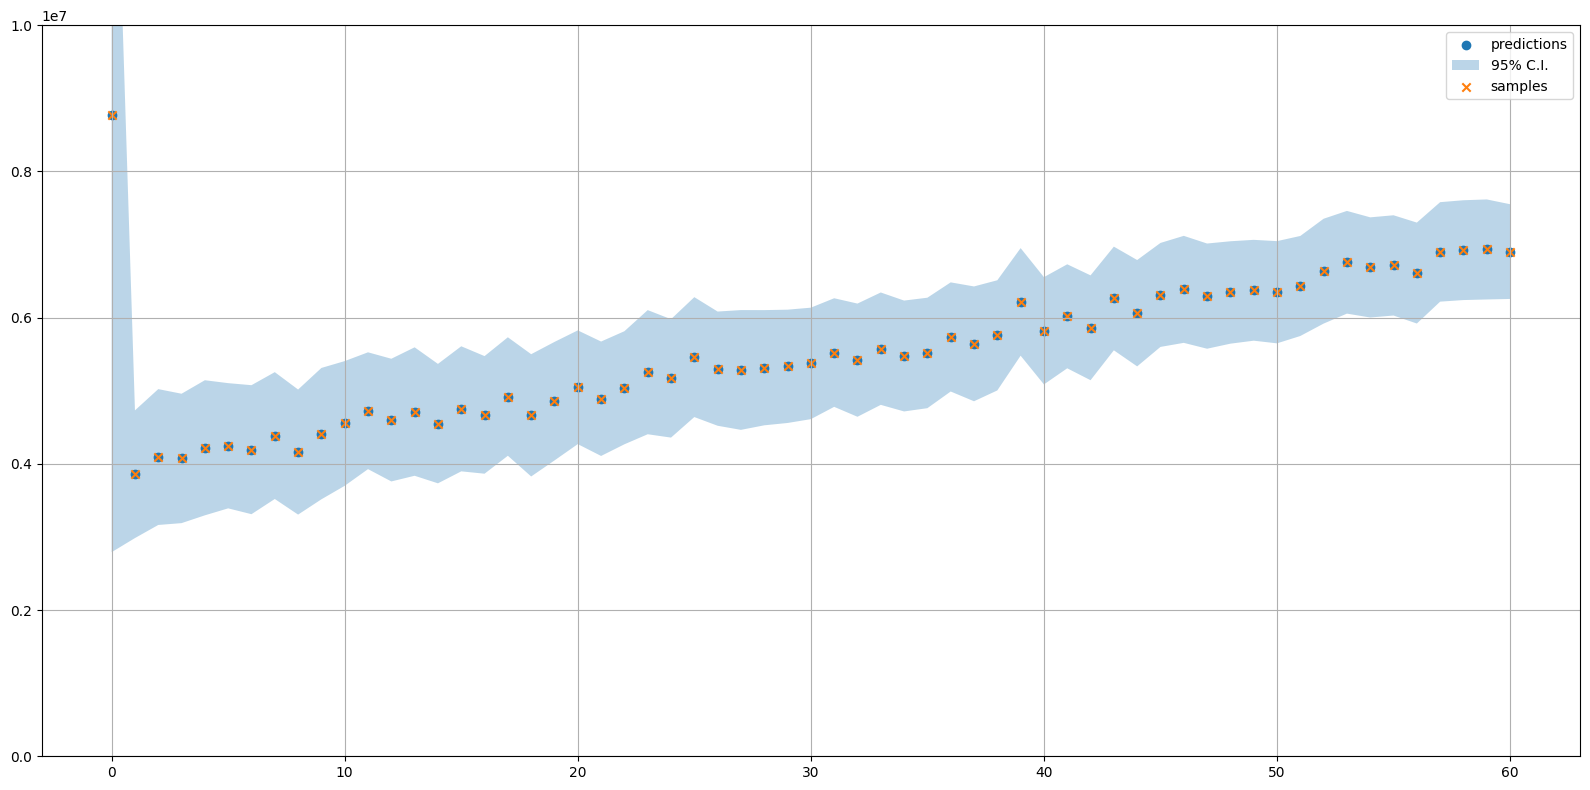

In [15]:
y_denorm = (y * y_std) + y_mean

plot_gp(
    pred = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    samples = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    std = np.array([x[0] for x in stds]) * y_std,
    figsize = (16, 8)
)

plt.ylim((0, 1e7))
# plt.plot(range(len(df_truth["Value"])), df_truth["Value"])

In [8]:
def plot_gp(target=None, pred=None, std=None, samples=None,
        target_samples=None, figsize=None):
    plt.figure(figsize=figsize)
    if target is not None:
        plt.plot(target.index, target, c='black', label='target')
    if pred is not None:
        plt.scatter(pred.index, pred, c='tab:blue',
                label='predictions')
    if std is not None:
        plt.fill_between(pred.index, pred-1.96*std, pred+1.96*std,
                alpha=.3, fc='tab:blue', ec='None',
                label='95% C.I.')
    # Add scatter plots
    if samples is not None:
        try:
            x = samples.index
            y = samples.values
        except AttributeError:
            x = samples[0]
            y = samples[1]
        plt.scatter(x, y, color='tab:orange',
              label='samples', marker='x')
    if target_samples is not None:
        try:
            x = target_samples.index
            y = target_samples.values
        except AttributeError:
            x = target_samples[0]
            y = target_samples[1]
        plt.scatter(x, y,
                color='black', label='target', s=5)
    plt.legend()
    plt.grid(':')
    plt.tight_layout()

In [50]:
def fill_missing_values_with_gp(df):
    """
    Fill missing values in the dataframe using Gaussian Processes.
    """
    for col in tqdm(df.columns):
        if df[col].isna().sum() > 0:  # Process columns with missing values
            # Extract observed data
            observed = df[col].dropna()
            X_observed = np.array(observed.index).reshape(-1, 1)  # Reshape index
            y_observed = observed.values

            # Extract missing data locations
            X_missing = np.array(df[df[col].isna()].index).reshape(-1, 1)

            # Define Gaussian Process
            # kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
            PARAM_RANGES = (1e-9, 1e5)

            kernel = WhiteKernel(0.1, PARAM_RANGES)
            kernel += ConstantKernel(1, PARAM_RANGES) * RBF(1, PARAM_RANGES)
            kernel += ConstantKernel(1, PARAM_RANGES) * DotProduct(1, PARAM_RANGES)
            gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

            # Fit GP to observed data
            gp.fit(X_observed, y_observed)

            # Predict missing values
            y_missing_pred, sigma = gp.predict(X_missing, return_std=True)

            # Fill missing values in the original dataframe
            df.loc[df[col].isna(), col] = y_missing_pred
    return df

df_filled = fill_missing_values_with_gp(df)
df_filled.describe()

  0%|          | 0/326 [00:00<?, ?it/s]c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-09. Decreasing the bound and cal

,Date,ex_factory_volumes,INNOVIX_months_of_treatment,YREX_months_of_treatment,INNOVIX_face-to-face-call_ind1,INNOVIX_face-to-face-call_ind2,INNOVIX_face-to-face-call_ind3,INNOVIX_face-to-face-call_ind4,INNOVIX_face-to-face-call_ind5,INNOVIX_face-to-face-call_ind6,...,YREX_indication_split_ind14,YREX_indication_split_ind15,YREX_indication_split_ind16,YREX_indication_split_ind17,YREX_indication_split_ind18,YREX_indication_split_ind19,YREX_indication_split_ind20,YREX_indication_split_ind21,YREX_indication_split_ind22,YREX_indication_split_ind23
count,82.000000,8.200000e+01,82.000000,82.000000,8.200000e+01,82.000000,82.0,82.0,82.0,82.0,...,82.000000,82.0,82.0,82.0,82.0,82.000000,82.000000,82.0,82.0,82.000000
mean,40.500000,3.917054e+06,7446.626009,13006.329038,1.580986e+02,204.496963,0.0,0.0,0.0,0.0,...,0.003324,0.0,0.0,0.0,0.0,0.715763,0.022359,0.0,0.0,0.042814
std,23.815261,5.189044e+05,1024.907299,9254.033465,1.648592e+02,238.228542,0.0,0.0,0.0,0.0,...,0.005165,0.0,0.0,0.0,0.0,0.090384,0.012689,0.0,0.0,0.016581
min,0.000000,2.611020e+06,6009.244155,-2642.730998,-4.043357e-10,-0.231251,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.536082,0.002891,0.0,0.0,0.002189
25%,20.250000,3.547195e+06,6656.770708,5182.256030,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.643947,0.017278,0.0,0.0,0.039980
50%,40.500000,3.834920e+06,7174.118900,13473.133950,1.262500e+02,184.750000,0.0,0.0,0.0,0.0,...,0.000027,0.0,0.0,0.0,0.0,0.727664,0.017408,0.0,0.0,0.040018
75%,60.750000,4.292570e+06,8190.293917,20827.303031,3.120000e+02,286.250000,0.0,0.0,0.0,0.0,...,0.006401,0.0,0.0,0.0,0.0,0.797725,0.026568,0.0,0.0,0.049310
max,81.000000,5.303380e+06,10448.201792,28975.411650,5.990000e+02,1278.000000,0.0,0.0,0.0,0.0,...,0.017831,0.0,0.0,0.0,0.0,0.832286,0.064739,0.0,0.0,0.086929


In [223]:
import warnings
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR



def generate_forecasts(positive_drop: float,positive_columns, negative_drop:float,negative_columns, maxlags: int = 5, drop_duration: int = 5):
    # Preprocessing the data
    dff = df_filled.set_index(["Date"], drop=False)

    X = dff.drop(columns=["ex_factory_volumes"])
    # Drop from X all the columns that have 0 std
    X = X.loc[:, X.std() != 0]
    # y = dff["ex_factory_volumes"]
    
    X_means = X.mean()
    X_stds = X.std()

    X_means["Date"] = 0
    X_stds["Date"] = 1
    
    X = (X - X_means) / X_stds
    
    

    # y_mean = y.mean()
    # y_std = y.std()
    # y = (y - y.mean()) / y.std()

    # Combine X and y for VAR model
    # data = pd.concat([X, y.rename("ex_factory_volumes")], axis=1)
    # display(data.describe())
    data = X

    # Initialize results container
    stds = []
    start_time = int(X.iloc[-1]["Date"])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        model = VAR(data)
        results = model.fit(maxlags=maxlags)
        
        if not results.is_stable:
            raise ValueError("Model is unstable. Check data or adjust lags.")
        num_dropped = 0
        for i in tqdm(range(40)):
            forecast_input = data.values[-results.k_ar:]
            forecast = results.forecast(y=forecast_input, steps=1)
            # print(forecast)            
            
            # Create the new sample
            new_sample = {col: val for col, val in zip(data.columns, forecast[0])}
            new_sample["Date"] = start_time
            
            # Introduce a simulated change at a specific future timestamp (e.g., 100)
            # print(start_time, num_dropped)
            if start_time >= 81 + 12 and num_dropped <= drop_duration:
                print("DIO MERDA")
                for positive_column in positive_columns:
                    for col in data.columns:
                        if col == positive_column:
                            de_norm = new_sample[col] * X_stds[positive_column] + X_means[positive_column]
                            new_sample[col] = (de_norm * (1 + positive_drop) - X_means[positive_column]) / X_stds[positive_column]  
                
                for negative_column in negative_columns:
                    for col in data.columns:
                        if col == negative_column:
                            de_norm = new_sample[col] * X_stds[negative_column] + X_means[negative_column]
                            new_sample[col] = (de_norm * (1 - negative_drop) - X_means[negative_column]) / X_stds[negative_column]
                num_dropped += 1
                        # new_sample[col] -= drop_amount  # Simulate a decrease
                    # elif col != "Date":
                    #     new_sample[col] = np.random.normal(data[col].mean(), data[col].std())
            
            # Append the new sample
            data = pd.concat([data, pd.DataFrame.from_dict([new_sample])], ignore_index=True)
            
            # Update the model
            model = VAR(data)
            results = model.fit(maxlags=maxlags)
            if not results.is_stable:
                print(f"Warning: Model became unstable at iteration {i}.")
            
            start_time += 1
            
    # print(results.params)
    return data


In [245]:
datas = []
for drop_amount in [0, 0.1, 0.2, 0.3]:
    data = generate_forecasts(positive_drop=drop_amount,
                                positive_columns=["YREX_months_of_treatment"],
                                negative_drop=drop_amount,
                                negative_columns=["INNOVIX_months_of_treatment"],
                                drop_duration=2, maxlags=15)
    # y_denorm = (data["ex_factory_volumes"] * y_std) + y_mean
    # y_denorm = (data["ex_factory_volumes"])
    
    # stds = np.array(stds) * (y_std)
    # datas.append((data, stds, y_mean, y_std, results))
    datas.append(data)
    # plt.plot(y_denorm, label=f"d:{drop_amount}")
# plt.legend()
# plt.show()

 40%|████      | 16/40 [00:00<00:00, 32.80it/s]

DIO MERDA
DIO MERDA
DIO MERDA


 40%|████      | 16/40 [00:00<00:00, 30.99it/s]

DIO MERDA
DIO MERDA
DIO MERDA


 40%|████      | 16/40 [00:00<00:00, 30.03it/s]

DIO MERDA
DIO MERDA
DIO MERDA


 40%|████      | 16/40 [00:00<00:00, 32.28it/s]

DIO MERDA
DIO MERDA
DIO MERDA


100%|██████████| 40/40 [00:01<00:00, 26.06it/s]


c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__noise_level is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified upper bound 1000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


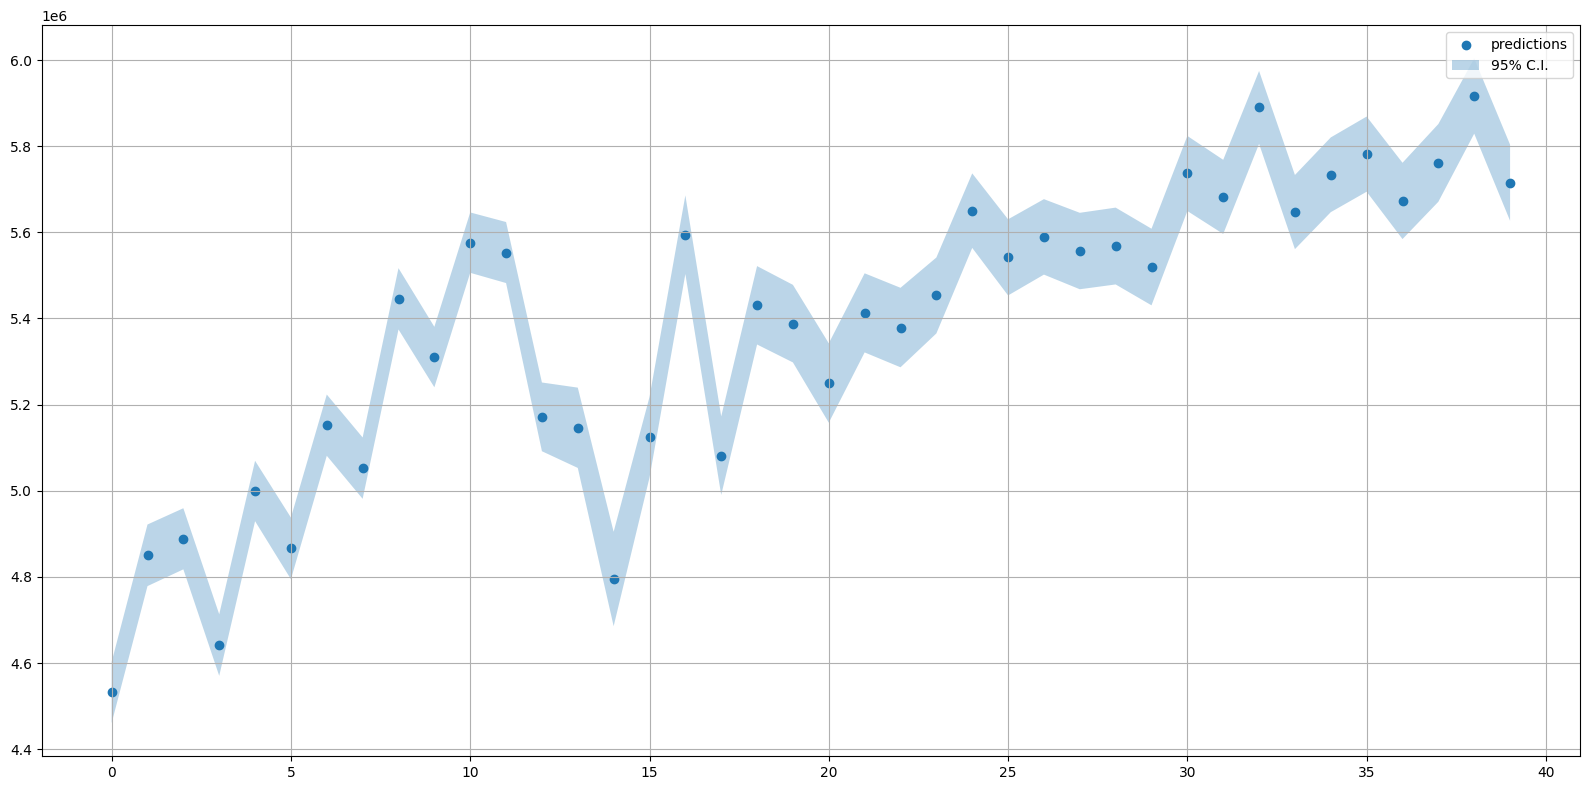

In [250]:
X_train = datas[1].iloc[:82]
y_train = df_filled["ex_factory_volumes"]
X_test = datas[1].iloc[82:]

# Define the gaussian process
PARAM_RANGES = (1e-9, 1e9)
kernel = WhiteKernel(0.1, PARAM_RANGES)
kernel += ConstantKernel(1, PARAM_RANGES) * RBF(1, PARAM_RANGES)
kernel += ConstantKernel(1, PARAM_RANGES) * DotProduct(1, PARAM_RANGES)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit the model
gp.fit(X_train, y_train)

# Predict the test set
pred, std = gp.predict(X_test, return_std=True)

# Plot the results
plot_gp(pred=pd.Series(index=range(len(pred)), data=pred), std=std, figsize=(16, 8))

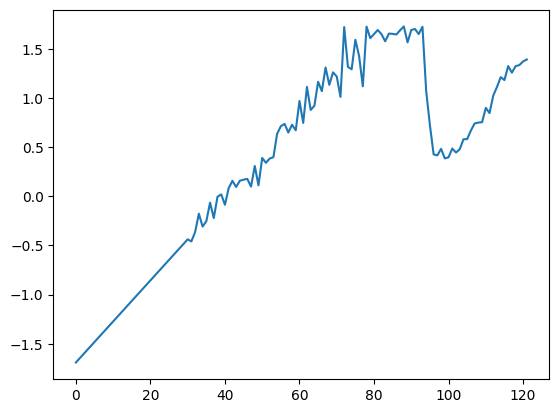

In [230]:
plt.plot(datas[2]["YREX_months_of_treatment"])

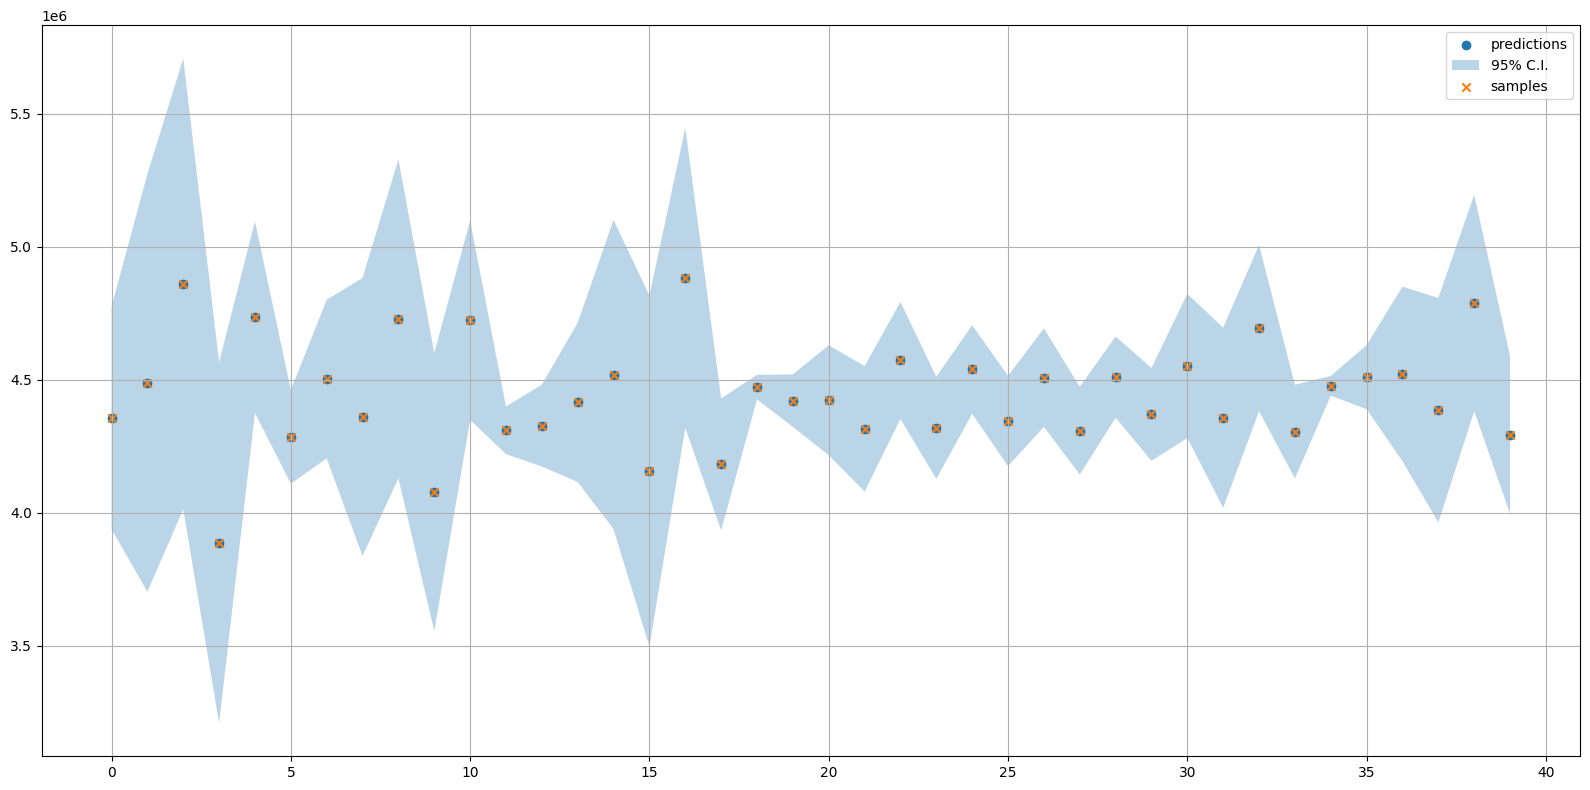

In [218]:
# y_denorm = (y * y_std) + y_mean
data, stds, y_mean, y_std, results = datas[0]
y_denorm = data["ex_factory_volumes"] * y_std + y_mean

plot_gp(
    pred = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    samples = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    std = np.array(stds),
    figsize = (16, 8)
)

# plt.ylim((0, 1e7))
# plt.plot(range(len(df_truth["Value"])), df_truth["Value"])

(0.0, 10000000.0)

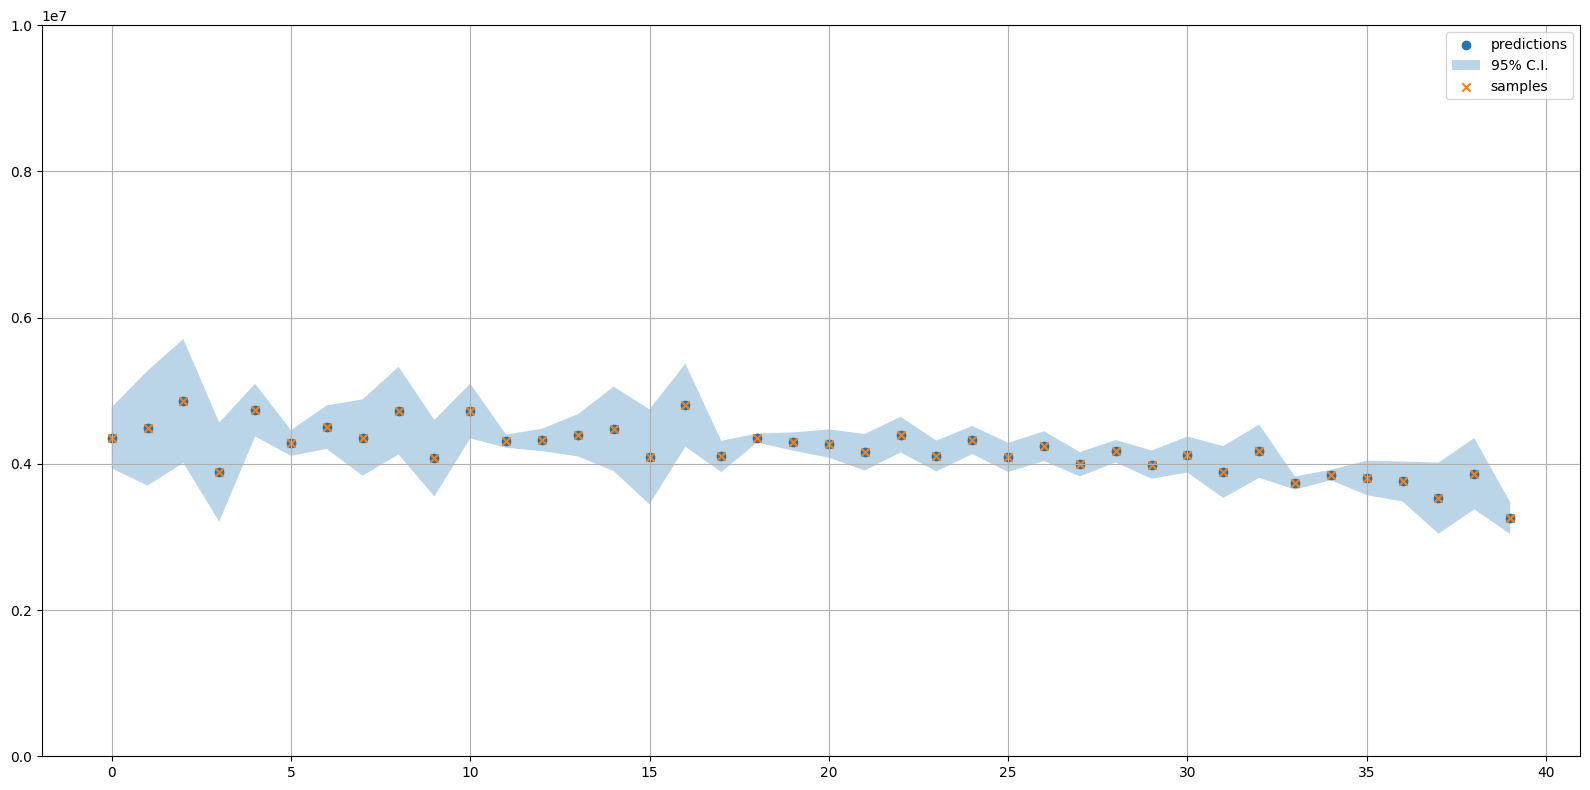

In [219]:
# y_denorm = (y * y_std) + y_mean
data, stds, y_mean, y_std, results = datas[-1]
y_denorm = data["ex_factory_volumes"] * y_std + y_mean

plot_gp(
    pred = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    samples = pd.Series(index=range(len(y_denorm[-len(stds):])), data=y_denorm[-len(stds):].values), 
    std = np.array(stds),
    figsize = (16, 8)
)

plt.ylim((0, 1e7))
# plt.plot(range(len(df_truth["Value"])), df_truth["Value"])

In [188]:
print(df_filled.corr()["ex_factory_volumes"]["YREX_months_of_treatment"])

0.6424798697671388


In [153]:
df_filled.corr()

,Date,ex_factory_volumes,INNOVIX_months_of_treatment,YREX_months_of_treatment,INNOVIX_face-to-face-call_ind1,INNOVIX_face-to-face-call_ind2,INNOVIX_face-to-face-call_ind3,INNOVIX_face-to-face-call_ind4,INNOVIX_face-to-face-call_ind5,INNOVIX_face-to-face-call_ind6,...,YREX_indication_split_ind14,YREX_indication_split_ind15,YREX_indication_split_ind16,YREX_indication_split_ind17,YREX_indication_split_ind18,YREX_indication_split_ind19,YREX_indication_split_ind20,YREX_indication_split_ind21,YREX_indication_split_ind22,YREX_indication_split_ind23
Date,1.000000,0.606794,0.826575,0.994663,0.639561,0.321288,NaN,NaN,NaN,NaN,...,0.687237,NaN,NaN,NaN,NaN,-0.954187,-0.017581,NaN,NaN,0.226815
ex_factory_volumes,0.606794,1.000000,0.800744,0.642480,0.487303,0.393369,NaN,NaN,NaN,NaN,...,0.404448,NaN,NaN,NaN,NaN,-0.590860,-0.125684,NaN,NaN,-0.049318
INNOVIX_months_of_treatment,0.826575,0.800744,1.000000,0.862735,0.578928,0.279318,NaN,NaN,NaN,NaN,...,0.561562,NaN,NaN,NaN,NaN,-0.798746,-0.081357,NaN,NaN,0.129130
YREX_months_of_treatment,0.994663,0.642480,0.862735,1.000000,0.639173,0.330800,NaN,NaN,NaN,NaN,...,0.681648,NaN,NaN,NaN,NaN,-0.953726,-0.004640,NaN,NaN,0.224425
INNOVIX_face-to-face-call_ind1,0.639561,0.487303,0.578928,0.639173,1.000000,0.541943,NaN,NaN,NaN,NaN,...,0.560068,NaN,NaN,NaN,NaN,-0.597931,0.009304,NaN,NaN,0.198675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YREX_indication_split_ind19,-0.954187,-0.590860,-0.798746,-0.953726,-0.597931,-0.280964,NaN,NaN,NaN,NaN,...,-0.678357,NaN,NaN,NaN,NaN,1.000000,0.026313,NaN,NaN,-0.236731
YREX_indication_split_ind20,-0.017581,-0.125684,-0.081357,-0.004640,0.009304,0.026916,NaN,NaN,NaN,NaN,...,-0.342290,NaN,NaN,NaN,NaN,0.026313,1.000000,NaN,NaN,0.345566
YREX_indication_split_ind21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YREX_indication_split_ind22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
print(df_filled.corr()["INNOVIX_months_of_treatment"]["YREX_months_of_treatment"])

0.8627349587704716
